In [ ]:
import os
from PIL import Image
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import center_of_mass

## set directories

In [ ]:
dataset_dir = r"C:\Users\abjawad\Documents\GitHub\local-attention-model\data"
colored_level = 'ColoredLabel'
depth_level = 'Depth'
hha = 'HHA'
label = 'Label'
rgb = 'RGB'
splits = 'splits.mat'
class_mapping = 'classMapping.csv'
output = 'output'

## class mapping

In [ ]:
# read csv file 
import pandas as pd
class_mapping_df = pd.read_csv(os.path.join(dataset_dir, class_mapping))
class_mapping_df.head()

In [ ]:

def read_image_from_id(path, id, img_type, format='jpg'):
    filename = f"{id}.{format}"  # or f"{id}.npy" depending on the image type
    filepath = os.path.join(path, img_type, filename)
    
    if os.path.exists(filepath):
        img = Image.open(filepath)  # or np.load(filepath) if the image type requires it
        return img
    else:
        print(f'File not found: {filepath}')
        return None



def display_images_for_ids(dataset_dir, ids, img_types=['RGB', 'Depth', 'Label', 'HHA', 'ColoredLabel']):
    # Prepare the figure
    num_ids = len(ids)
    num_types = len(img_types)
    fig, ax = plt.subplots(num_ids, num_types, figsize=(10, 2 * num_ids))

    # If we only have one subplot, ax will be 1D. We need it to always be 2D.
    if ax.ndim == 1:
        ax = ax.reshape(-1, 1)

    # Loop over each id and each image type
    for i, id in enumerate(ids):
        for j, img_type in enumerate(img_types):
            img = None
            if img_type == 'Depth':
                img = np.load(os.path.join(dataset_dir, img_type, f'{id}.npy'))
            
            if img_type == 'RGB':
                img = read_image_from_id(dataset_dir, id, img_type, format='jpg')
                
            elif img_type == 'Label':
                img = read_image_from_id(dataset_dir, id, img_type, format='png')
                
            elif img_type == 'HHA':
                img = read_image_from_id(dataset_dir, id, img_type, format='jpg')
                
            elif img_type == 'ColoredLabel':
                img = read_image_from_id(dataset_dir, id, img_type, format='png')

            if img is not None:
                ax[i, j].imshow(img)
                ax[i, j].set_title(f'{img_type} {id}')
            else:
                ax[i, j].set_title(f'{img_type} {id} (not found)')
                ax[i, j].axis('off')
            
    plt.show()

## Show output data

In [ ]:
ids = [0,1,2]
display_images_for_ids(dataset_dir, ids, img_types=['RGB', 'Depth', 'Label', 'HHA', 'ColoredLabel'])

In [ ]:


# Set range of IDs to process
ids = [0,1,2]

# Create a mapping dictionary from ID to class name
id_to_class_name = dict(zip(class_mapping_df['id_40'], class_mapping_df['new_name']))

for id in ids:
    # Read the image and labels
    label = np.array(read_image_from_id(dataset_dir, id, 'Label', format='png'))
    image = np.array(read_image_from_id(dataset_dir, id, 'RGB', format='jpg'))

    if image is not None and label is not None:
        # Identify the unique labels in the current label image
        unique_values = np.unique(label)
        unique_names = [id_to_class_name.get(val, 'unknown') for val in unique_values]

        # Iterate over each unique label and overlay it on the RGB image
        for val, name in zip(unique_values, unique_names):
            # Calculate the centroid of the region corresponding to the current label
            centroid = center_of_mass(label == val)
            
            # OpenCV expects coordinates in (x, y) format
            centroid = (int(centroid[1]), int(centroid[0]))
            
            # Draw the class name on the RGB image
            cv2.putText(image, name, centroid, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Display the annotated RGB image
        plt.imshow(image)
        plt.show()

        # Print size of the image
        print(f'Image {id} size: {image.shape[:2]}')
    else:
        print(f'Image {id} not found.')


In [ ]:
# # Set range of IDs to process
# ids = range(10)

# # Create a mapping dictionary from ID to class name
# id_to_class_name = dict(zip(class_mapping_df['id_40'], class_mapping_df['new_name']))

# for id in ids:
#     # Read the image
#     label = read_image_from_id(dataset_dir, id, 'Label', format='png')
#     image = read_image_from_id(dataset_dir, id, 'RGB', format='jpg')

#     # Check if image is loaded
#     if label is not None:
#         # Display the image
#         plt.imshow(image)
#         plt.show()

#         # Print size of the image
#         print(f'Image {id} size: {label.size}')

#         # Check and print distinct values
#         unique_values = np.unique(label)
#         unique_values_names = [id_to_class_name.get(val, 'unknown') for val in unique_values]

#         print(f'Unique values in Image {id}: {unique_values}')
#         print(f'Corresponding class names: {unique_values_names}')
#     else:
#         print(f'Image {id} not found.')


## show distribution

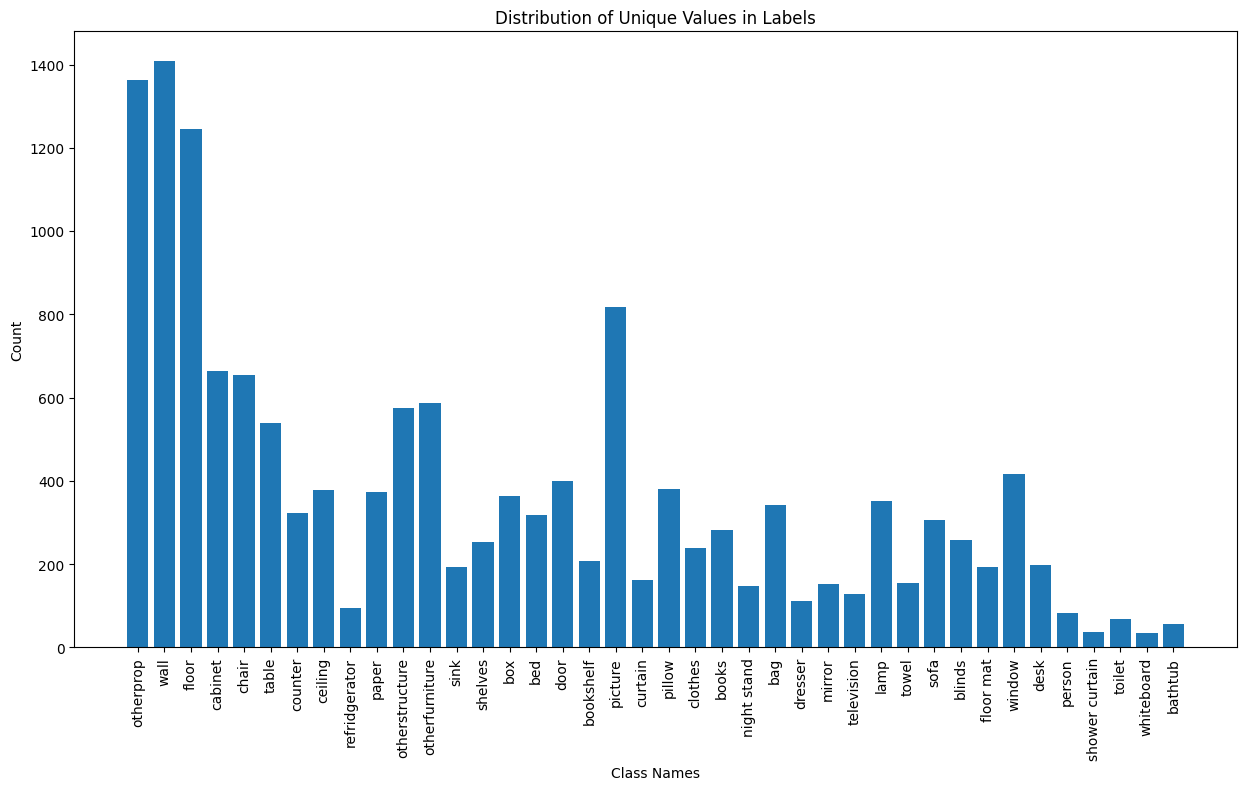

In [11]:
import os
from collections import Counter

# Get all IDs in the Label directory
label_dir = os.path.join(dataset_dir, 'Label')
ids = [int(filename.split('.')[0]) for filename in os.listdir(label_dir) if filename.endswith('.png')]

# Initialize counter for unique values
unique_values_counter = Counter()

# Loop over each ID
for id in ids:
    # Read the image
    label = read_image_from_id(dataset_dir, id, 'Label', format='png')

    # Check if image is loaded
    if label is not None:
        # Get unique values in the image and update the counter
        unique_values = np.unique(label)
        unique_values_counter.update(unique_values)

# Show distribution of unique values
# for value, count in unique_values_counter.items():
#     print(f'Value: {value}, Count: {count}')

# Create a mapping dictionary from ID to class name
id_to_class_name = dict(zip(class_mapping_df['id_40'], class_mapping_df['new_name']))

# Create a new counter where keys are class names
class_name_counter = Counter({id_to_class_name.get(id, 'unknown'): count for id, count in unique_values_counter.items()})

# Plot histogram of unique values
plt.figure(figsize=(15,8))  # Increase size of the plot
plt.bar(class_name_counter.keys(), class_name_counter.values())
plt.xlabel('Class Names')
plt.ylabel('Count')
plt.title('Distribution of Unique Values in Labels')
plt.xticks(rotation='vertical')  # Rotate x-axis labels for better visibility
plt.show()
